<a href="https://colab.research.google.com/github/AmirRazaMBA/Tensorflow-in-Practice-Specialization/blob/main/3.%20Natural%20Language%20Processing%20in%20TensorFlow/Codes/Exam%20Prep/RNN/02_nlp_multiple_models_for_predicting_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using LSTMs, CNNs, GRUs with a larger dataset

In this colab, you use different kinds of layers to see how they affect the model.

You will use the glue/sst2 dataset, which is available through tensorflow_datasets. 

The General Language Understanding Evaluation (GLUE) benchmark (https://gluebenchmark.com/) is a collection of resources for training, evaluating, and analyzing natural language understanding systems.

These resources include the Stanford Sentiment Treebank (SST) dataset that consists of sentences from movie reviews and human annotations of their sentiment. This colab uses version 2 of the SST dataset.

The splits are:

*   train	67,349
*   validation	872


and the column headings are:

*   sentence
*   label


For more information about the dataset, see [https://www.tensorflow.org/datasets/catalog/glue#gluesst2](https://www.tensorflow.org/datasets/catalog/glue#gluesst2)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

# Get the dataset


In [2]:
# Get the dataset.
# It has 70000 items, so might take a while to download
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteJQOL0L/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteJQOL0L/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteJQOL0L/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
2
['negative', 'positive']


In [3]:
# Get the training and validation datasets
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [4]:
# Print some of the entries
for example in dataset_train.take(2):  
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [5]:
# Get the sentences and the labels
# for both the training and the validation sets
training_reviews = []
training_labels = []
 
validation_reviews = []
validation_labels = []

# The dataset has 67,000 training entries, but that's a lot to process here!

# If you want to take the entire dataset: WARNING: takes longer!!
# for item in dataset_train.take(-1):

# Take 10,000 reviews
for item in dataset_train.take(10000):
  review, label = item["sentence"], item["label"]
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_reviews))

# print some of the reviews and labels
for i in range(0, 2):
  print (training_reviews[i])
  print (training_labels[i])

# Get the validation data
# there's only about 800 items, so take them all
for item in dataset_validation.take(-1):  
  review, label = item["sentence"], item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_reviews[i])
  print (validation_labels[i])



Number of training reviews is:  10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


# Tokenize the words and sequence the sentences


In [7]:
# There's a total of 21224 words in the reviews
# but many of them are irrelevant like with, it, of, on.
# If we take a subset of the training data, then the vocab
# will be smaller.

# A reasonable review might have about 50 words or so,
# so we can set max_length to 50 (but feel free to change it as you like)

vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index


# Pad the sequences

In [8]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

# Create the model using an Embedding

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),   # Flatten or GAP
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            64000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [10]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels_final))


Epoch 1/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6837 - accuracy: 0.5590 - val_loss: 0.6941 - val_accuracy: 0.5080
Epoch 2/20
313/313 [==============================] - 1s 3ms/step - loss: 0.6740 - accuracy: 0.5678 - val_loss: 0.6742 - val_accuracy: 0.5917
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6538 - accuracy: 0.6171 - val_loss: 0.6480 - val_accuracy: 0.6445
Epoch 4/20
313/313 [==============================] - 1s 3ms/step - loss: 0.6249 - accuracy: 0.6671 - val_loss: 0.6175 - val_accuracy: 0.6846
Epoch 5/20
313/313 [==============================] - 1s 3ms/step - loss: 0.5914 - accuracy: 0.7087 - val_loss: 0.5859 - val_accuracy: 0.7064
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5586 - accuracy: 0.7374 - val_loss: 0.5572 - val_accuracy: 0.7317
Epoch 7/20
313/313 [==============================] - 1s 3ms/step - loss: 0.5268 - accuracy: 0.7642 - val_loss: 0.5348 - val_accuracy: 0.7374
Epoch 

# Plot the accurracy and loss

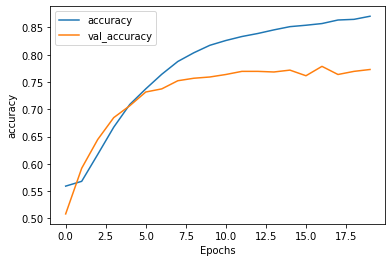

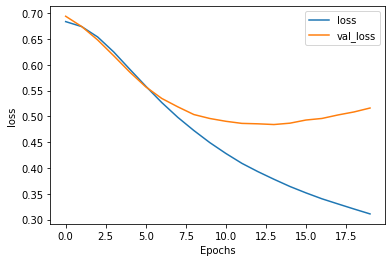

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Write a function to predict the sentiment of reviews

In [12]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]


In [13]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews           

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)


I loved this movie
[0.3807171]


that was the worst movie I've ever seen
[0.111787]


too much violence even for a Bond film
[0.03099431]


a captivating recounting of a cherished myth
[0.57220185]




# Define a function to train and show the results of models with different layers

In [15]:
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

# Use a CNN

Convolutional Layers for Text

Just like you did with images, you can also use convolutional layers on text, where the convolution occurs across a sequence of words instead of across an image.

To use a convolutional layer on text inputs, you can place a Conv1D layer directly after the Embedding layer:

# A 1D Convolutional layer with 128 filters and 5 words per filter
tf.keras.layers.Conv1D(128, 5, activation=’relu’)

Note that you will need to use Flatten or GlobalAveragePooling1D on the output of this layer to connect to any fully-connected layers from there.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 1s 4ms/step - loss: 0.6882 - accuracy: 0.5572 - val_loss: 0.6920 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 1s 4ms/step - loss: 0.6821 - accuracy: 0.5590 - val_

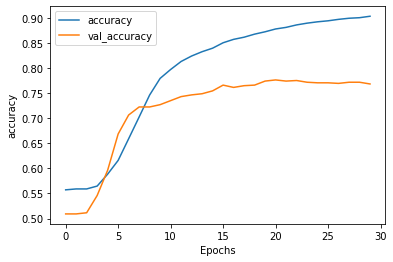

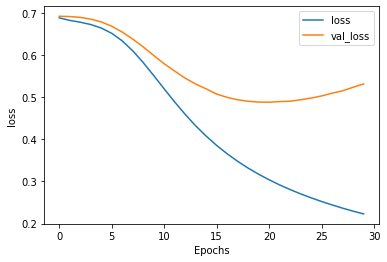

I loved this movie
[0.89378136]


that was the worst movie I've ever seen
[0.04757899]


too much violence even for a Bond film
[0.00461861]


a captivating recounting of a cherished myth
[0.7117321]




In [16]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

# Use a GRU

GRUs

Gated Recurrent Units, or GRUs, have “update” and “reset” gates. These gates decide what to keep and what to throw away. They do not have a “cell state” like LSTMs do.

The code for these is very similar to an LSTM, where the GRU layer is wrapped in a Bidirectional layer.

# A bidirectional GRU layer with 32 nodes
tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 4s 12ms/step - loss: 0.6908 - accuracy: 0.5472 - val_loss: 0.6927 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 3s 9ms/step - loss: 0.6872 - accuracy: 0.5590 - val_loss: 0.6932 - val_accuracy: 0.5092
Epoch 3/30
313/313 [==============================] - 3s 9ms/step - loss: 0.6856 - accuracy: 0.

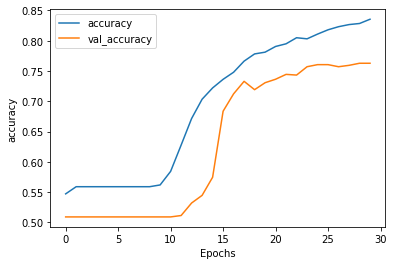

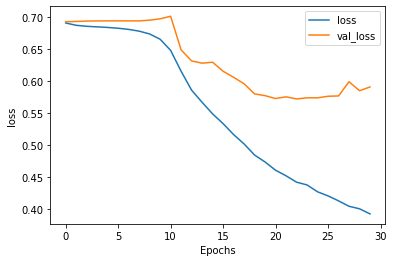

I loved this movie
[0.38715523]


that was the worst movie I've ever seen
[0.17752028]


too much violence even for a Bond film
[0.16312794]


a captivating recounting of a cherished myth
[0.46779042]




In [17]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

# Add a bidirectional LSTM

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 3s 11ms/step - loss: 0.6907 - accuracy: 0.5590 - val_loss: 0.6928 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 3s 10ms/step - loss: 0.6882 - accuracy: 0.5590 - val_loss: 0.6930 - val_accuracy: 0.5092
Epoch 3/30
313/313 [==============================] - 3s 9ms/step - loss: 0.6861 - accuracy: 0

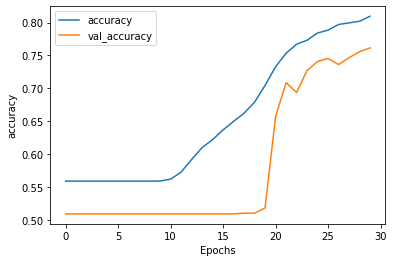

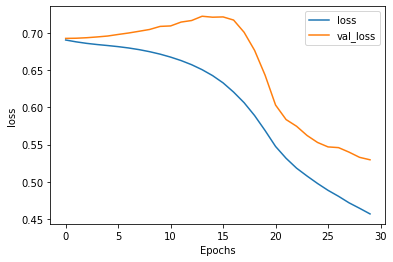

I loved this movie
[0.40409368]


that was the worst movie I've ever seen
[0.2644698]


too much violence even for a Bond film
[0.34534287]


a captivating recounting of a cherished myth
[0.4592929]




In [18]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

# Use multiple bidirectional LSTMs

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 6s 19ms/step - loss: 0.6811 - accuracy: 0.5675 - val_loss: 0.7301 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 5s 15ms/step - loss: 0.5239 - accuracy: 0.7404 - va

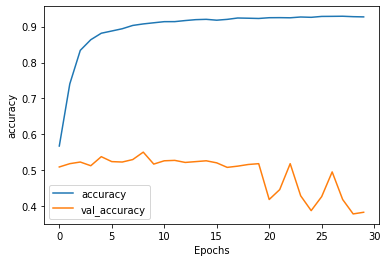

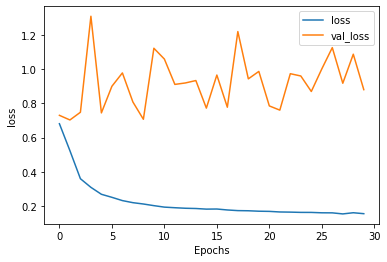

I loved this movie
[0.02748207]


that was the worst movie I've ever seen
[0.02391966]


too much violence even for a Bond film
[0.01940762]


a captivating recounting of a cherished myth
[0.99293584]




In [19]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

# Try some more reviews

In [26]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7, 
               review8, review9, review10]


In [27]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
I loved this movie
[0.3807171]


that was the worst movie I've ever seen
[0.111787]


too much violence even for a Bond film
[0.03099431]


a captivating recounting of a cherished myth
[0.57220185]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.2800884]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.471253]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.25067797]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.49579304]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.01116972]


I wish I could 

In [22]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
I loved this movie
[0.89378136]


that was the worst movie I've ever seen
[0.04757899]


too much violence even for a Bond film
[0.00461861]


a captivating recounting of a cherished myth
[0.7117321]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.77569705]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.5458434]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.27848166]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.5172174]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.04864404]


I wish I could watch

In [23]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
I loved this movie
[0.38715523]


that was the worst movie I've ever seen
[0.17752028]


too much violence even for a Bond film
[0.16312794]


a captivating recounting of a cherished myth
[0.46779042]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.09256152]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.11844901]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.135713]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.25724983]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.06791613]


I wis

In [24]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
I loved this movie
[0.40409368]


that was the worst movie I've ever seen
[0.2644698]


too much violence even for a Bond film
[0.34534287]


a captivating recounting of a cherished myth
[0.4592929]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.1823653]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.21519479]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.21755144]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.2994834]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.16266577

In [25]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
I loved this movie
[0.02748207]


that was the worst movie I've ever seen
[0.02391966]


too much violence even for a Bond film
[0.01940763]


a captivating recounting of a cherished myth
[0.99293584]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.06882999]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.04671533]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.9944155]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.10473961]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.02639

Further Research: TensorFlow Documentation

    Documentation for GRU layers in TensorFlow https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU
    Documentation for LSTM layers in TensorFlow
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
    Documentation for 1D Convolutional layers in TensorFlow
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

https://youtu.be/2hf8Z52cZIc